## The Questionnaire Process, Recovery, and Reconstruction

In this example, we generate a sample probability field with intrinsic geometry in both dimensions. We sample the probability field, permute the rows and columns, producing a set of empirical data that looks like noise to the eye. We then apply the questionnaire methods to reconstruct and recover the original probability field.

In [1]:
from imports import *
bal_constant = 1.2
flex_constant = 0.5

We define the sample probability field to be a $300 \times 150$ matrix $P$. We let $i$ and $j$ vary uniformly on $\left[0,2\pi\right]$ over the rows and columns of the matrix respectively. Then we let the entries of the matrix be $P(i,j) = \frac{1}{2} \left(1 + \sin\left(\frac{i+j+2ij}{2}\right)\right)$. We then sample from the field, taking successes to be $+1$ and failures to be $-1$.

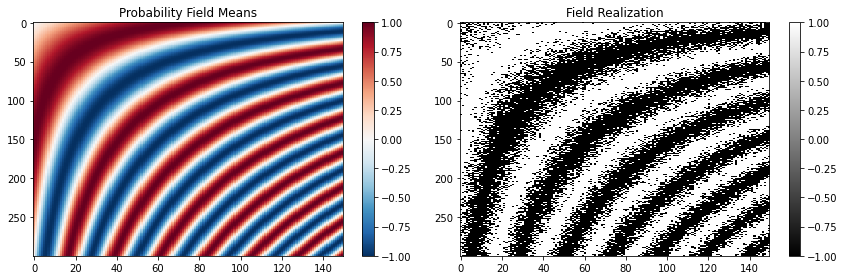

In [2]:
n_rows,n_columns = 300,150
means_matrix = np.zeros([n_rows,n_columns])
for i in range(n_rows):
    for j in range(n_columns):
        ii = i*2.0*np.pi/n_rows
        jj = j*2.0*np.pi/n_columns
        means_matrix[i,j] = np.sin((ii+jj+2*ii*jj)/2.0)*1.0
        
np.random.seed(20140301)
pf = artificial_data.ProbabilityField(means_matrix/2.0+0.5)
orig_data = pf.realize()

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
cplot(means_matrix,colorbar=True,title="Probability Field Means")
fig.add_subplot(122)
bwplot2(orig_data,colorbar=True,title="Field Realization")
plt.tight_layout()
plt.show()

Next we generate a random permutation of the rows and a random permutation of the columns, and take the result of that to be the empirical data with which we are presented.

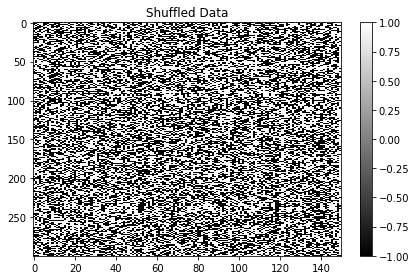

In [3]:
row_shuffle_order = np.random.rand(n_rows).argsort()
col_shuffle_order = np.random.rand(n_columns).argsort()
shuffled_means_matrix = means_matrix[row_shuffle_order,:][:,col_shuffle_order]
data = orig_data[row_shuffle_order,:][:,col_shuffle_order]
inverse_row_order = row_shuffle_order.argsort()
inverse_col_order = col_shuffle_order.argsort()
fig = plt.figure(figsize=(6,4))
bwplot2(data,colorbar=True,title="Shuffled Data")
plt.tight_layout()
plt.show()

So our task, then, is to take this dataset of 45,000 "yes" or "no" answers, and using only the knowledge that the underlying probability field from which it was sampled is smooth with respect to some geometry on the rows and columns jointly, to recover the probability field and the permutations of rows and columns from which it came.

### The Questionnaire Process

We begin by computing an affinity between rows. We will use cosine similarity as the initial affinity, thresholding at $0.05$. The bright white diagonal line is the perfect affinity of each row with itself, while the gray represent varying degrees of affinity between different vectors. 

We take this initial affinity and calculate the eigenvectors and eigenvalues of the approximate bistochastic Markov matrix, producing a diffusion embedding of the rows.

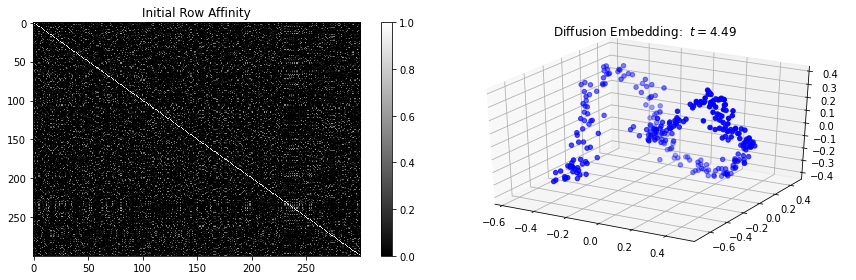

In [4]:
init_row_aff = affinity.mutual_cosine_similarity(data.T,threshold=0.05)
init_row_vecs,init_row_vals = markov.markov_eigs(init_row_aff,12)
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
bwplot(init_row_aff,colorbar=True,title="Initial Row Affinity")
ax = fig.add_subplot(122,projection="3d")
plot_embedding(init_row_vecs,init_row_vals,ax=ax)
plt.tight_layout()
plt.show()

Now based on this diffusion embedding, we will construct a tree on the rows. We organize the data by rows and plot the result; despite the noisiness of the resulting plot, some structure can be seen.

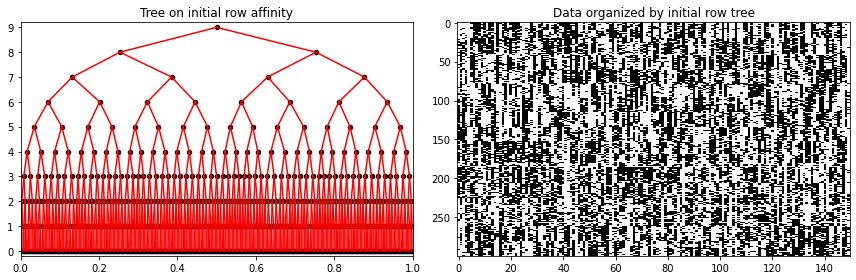

In [5]:
init_row_tree = bin_tree_build.bin_tree_build(init_row_aff,'r_dyadic',bal_constant)
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plot_tree(init_row_tree,title="Tree on initial row affinity")
fig.add_subplot(122)
bwplot2(barcode.organize_rows(init_row_tree,data),title="Data organized by initial row tree")
plt.tight_layout()
plt.show()

Next we repeat the identical process for the columns.

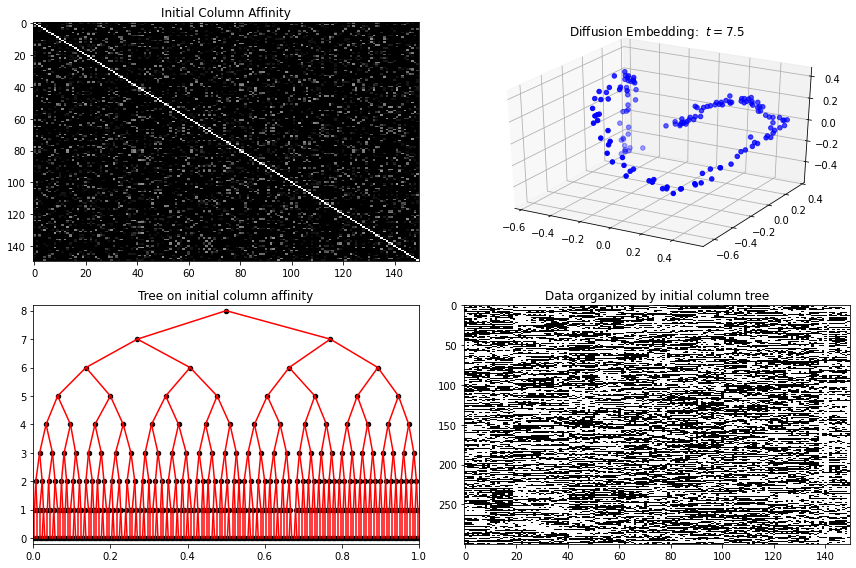

In [6]:
init_col_aff = affinity.mutual_cosine_similarity(data,threshold=0.05)
init_col_vecs,init_col_vals = markov.markov_eigs(init_col_aff,12)
fig = plt.figure(figsize=(12,8))
fig.add_subplot(221)
bwplot(init_col_aff,colobar=True,title="Initial Column Affinity")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(init_col_vecs,init_col_vals,ax=ax)
init_col_tree = bin_tree_build.bin_tree_build(init_col_aff,'r_dyadic',bal_constant)
fig.add_subplot(223)
plot_tree(init_col_tree,title="Tree on initial column affinity")
fig.add_subplot(224)
bwplot2(barcode.organize_cols(init_col_tree,data),
        title="Data organized by initial column tree")
plt.tight_layout()
plt.show()

We can combine these initial trees by organizing the rows according to the row trees and the columns according to the column tree. Already in this we can see that the partition trees are creating submatrices of near-constant value, even though the data is still quite noisy.

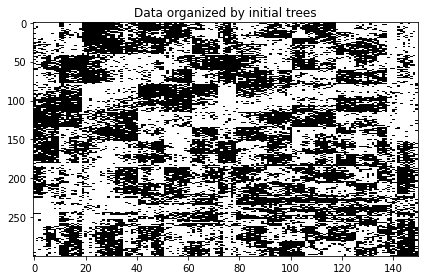

In [7]:
bwplot2(barcode.organize_folders(init_row_tree,init_col_tree,data),
        title="Data organized by initial trees")
plt.tight_layout()
plt.show()

We proceed by calculating the Earth Mover's Distance (EMD) with constant $\beta=1.0$ for the rows based on the organization of the columns.

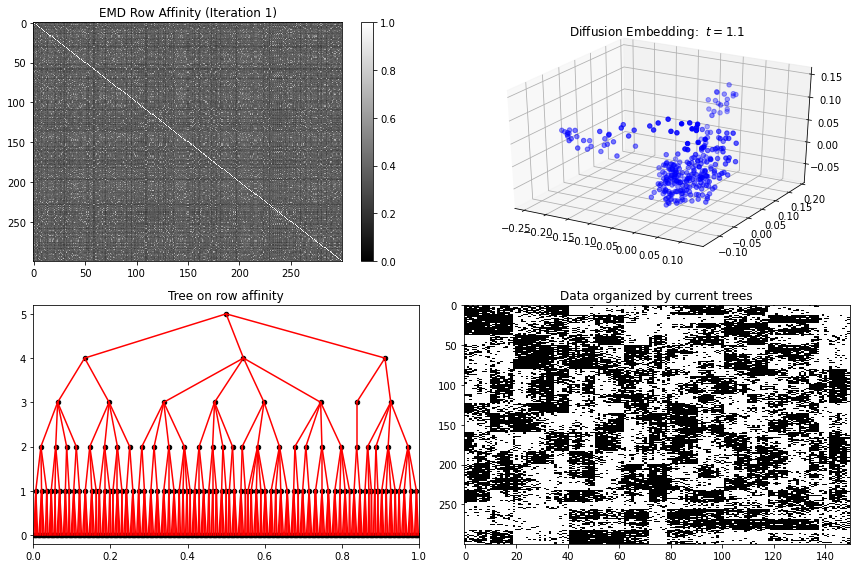

In [8]:
row_emd = dual_affinity.calc_emd(data.T,init_col_tree,alpha=0.0,beta=1.0)
row_affinity = affinity.threshold(dual_affinity.emd_dual_aff(row_emd),0.0)
row_vecs,row_vals = markov.markov_eigs(row_affinity,12)
fig = plt.figure(figsize=(12,8))
fig.add_subplot(221)
bwplot(row_affinity,colorbar=True,title="EMD Row Affinity (Iteration 1)")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(row_vecs,row_vals,ax=ax)
row_tree = flex_tree_build.flex_tree(row_affinity,flex_constant)
fig.add_subplot(223)
plot_tree(row_tree,title="Tree on row affinity")
fig.add_subplot(224)
bwplot2(barcode.organize_folders(row_tree,init_col_tree,data),
        title="Data organized by current trees")
plt.tight_layout()
plt.show()

And we can now calculate the EMD and associated diffusion map and tree on the columns, using the newly generated row tree. We repeat this process for a total of two iterations below.

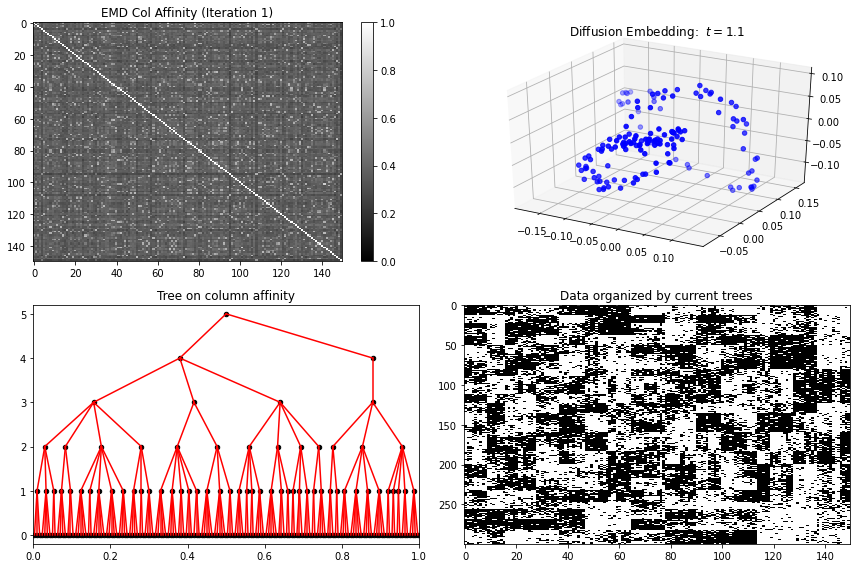

In [9]:
col_emd = dual_affinity.calc_emd(data,row_tree,alpha=0.0,beta=1.0)
col_affinity = affinity.threshold(dual_affinity.emd_dual_aff(col_emd),0.0)
col_vecs,col_vals = markov.markov_eigs(col_affinity,12)
fig = plt.figure(figsize=(12,8))
fig.add_subplot(221)
bwplot(col_affinity,colorbar=True,title="EMD Col Affinity (Iteration 1)")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(col_vecs,col_vals,ax=ax)
col_tree = flex_tree_build.flex_tree(col_affinity,flex_constant)
fig.add_subplot(223)
plot_tree(col_tree,title="Tree on column affinity")
fig.add_subplot(224)
bwplot2(barcode.organize_folders(row_tree,col_tree,data),
        title="Data organized by current trees")
plt.tight_layout()
plt.show()

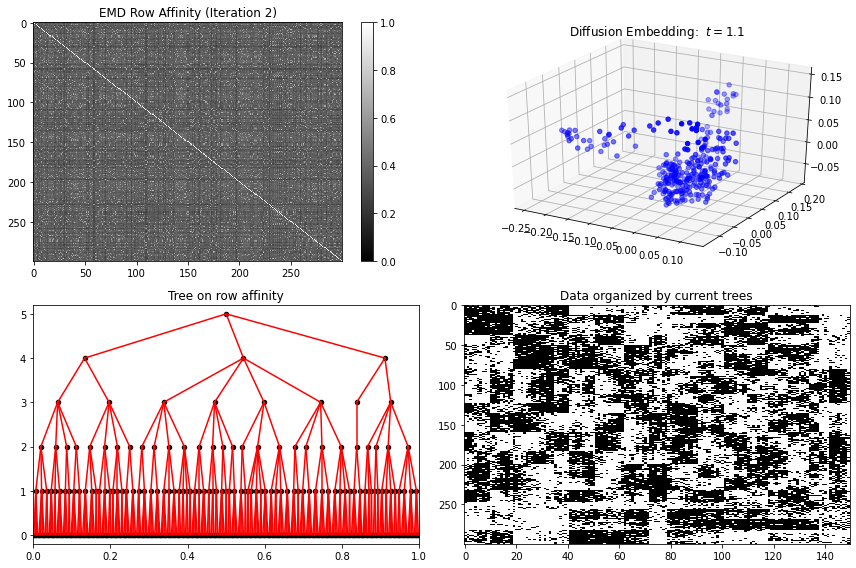

In [10]:
row_emd = dual_affinity.calc_emd(data.T,init_col_tree,alpha=0.0,beta=1.0)
row_affinity = affinity.threshold(dual_affinity.emd_dual_aff(row_emd),0.0)
row_vecs,row_vals = markov.markov_eigs(row_affinity,12)
fig = plt.figure(figsize=(12,8))
fig.add_subplot(221)
bwplot(row_affinity,colorbar=True,title="EMD Row Affinity (Iteration 2)")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(row_vecs,row_vals,ax=ax)
row_tree = flex_tree_build.flex_tree(row_affinity,flex_constant)
fig.add_subplot(223)
plot_tree(row_tree,title="Tree on row affinity")
fig.add_subplot(224)
bwplot2(barcode.organize_folders(row_tree,init_col_tree,data),
        title="Data organized by current trees")
plt.tight_layout()
plt.show()

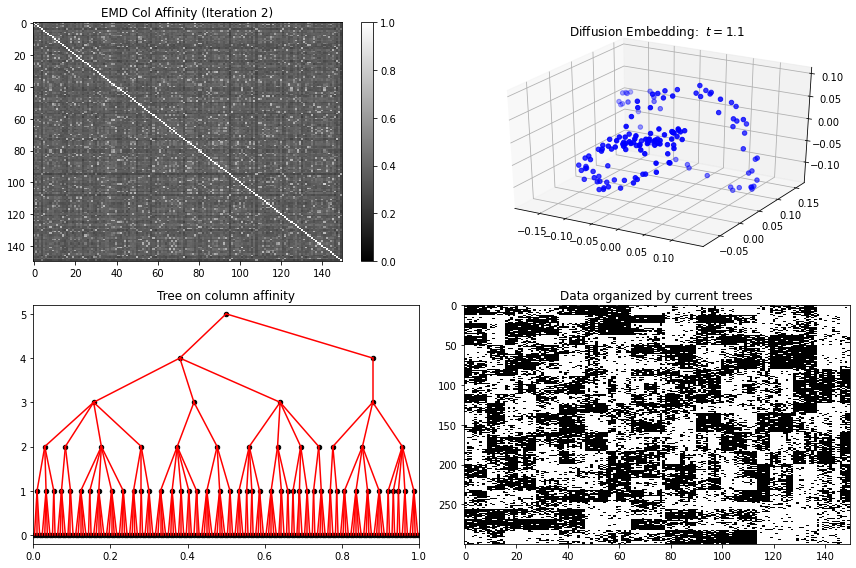

In [11]:
col_emd = dual_affinity.calc_emd(data,row_tree,alpha=0.0,beta=1.0)
col_affinity = affinity.threshold(dual_affinity.emd_dual_aff(col_emd),0.0)
col_vecs,col_vals = markov.markov_eigs(col_affinity,12)
fig = plt.figure(figsize=(12,8))
fig.add_subplot(221)
bwplot(col_affinity,colorbar=True,title="EMD Col Affinity (Iteration 2)")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(col_vecs,col_vals,ax=ax,title="Diffusion Embedding: ")
col_tree = flex_tree_build.flex_tree(col_affinity,flex_constant)
fig.add_subplot(223)
plot_tree(col_tree,title="Tree on column affinity")
fig.add_subplot(224)
bwplot2(barcode.organize_folders(row_tree,col_tree,data),
        title="Data organized by current trees")
plt.tight_layout()
plt.show()

### Recovering the Row and Column Permutations

Now in the lower right above we have organized the data by the trees, and obviously in this organization, we see that there are many submatrices of near-constant value. But as was pointed out in the section on tree-building, there is no single permutation of rows and columns that correspond to a particular pair of trees, so we cannot expect to recover exactly the original permutation of the rows and columns. Instead, many trees areequivalent. But we can often recover the original permutation in the following manner.

We begin by calculating affinities on the rows and columns with fairly high thresholds (choosing a precise one is data-dependent). Here we choose $0.51$. This collapses the diffusion maps to a curve. We calculate those diffusion maps at diffusion time $t=1$. Then we choose a random starting point along the curve (say $x$). The next point of our ordering is the nearest neighbor of $x$ (in diffusion distance) that is not already in our ordering. By doing this, we pick a direction and walk along the curve in a parametric manner.

Now we may pick a starting point in the middle of the curve, in which case our ordering will have a large jump in it as we reach the end of the parameteric curve in diffusion space. However, we can easily detect this by reorganizing the data according to the permutation we have just obtained. We then choose a new starting point $x$ to coincide with the largest distance between any two consecutive points in our ordering, which will generally coincide with such a jump. In this way, we can recover an appproximation of the original permutation of the data.


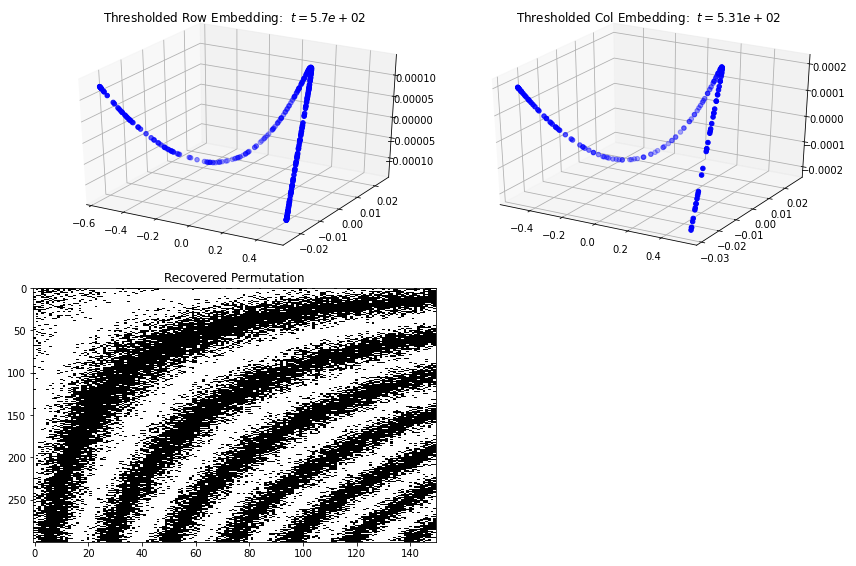

In [12]:
row_emd = dual_affinity.calc_emd(data.T,col_tree,alpha=0.0,beta=1.0)
col_emd = dual_affinity.calc_emd(data,row_tree,alpha=0.0,beta=1.0)
row_affinity = affinity.threshold(dual_affinity.emd_dual_aff(row_emd),0.53)
row_vecs,row_vals = markov.markov_eigs(row_affinity,12)
col_affinity =  affinity.threshold(dual_affinity.emd_dual_aff(col_emd),0.53)
col_vecs,col_vals = markov.markov_eigs(col_affinity,12)

row_order,col_order = barcode.organize_diffusion(data,row_vecs.dot(np.diag(row_vals)),
                                  col_vecs.dot(np.diag(col_vals)))
#reversed the orders here; if we don't do this, then the permutation is a mirror image
#of the original.
row_order = [x for x in reversed(row_order)]
#col_order = [x for x in reversed(col_order)]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(221,projection="3d")
plot_embedding(row_vecs,row_vals,ax=ax,title="Thresholded Row Embedding: ")
ax = fig.add_subplot(222,projection="3d")
plot_embedding(col_vecs,col_vals,ax=ax,title="Thresholded Col Embedding: ")
fig.add_subplot(223)
bwplot2(data[row_order,:][:,col_order],title="Recovered Permutation")
plt.tight_layout()
plt.show()

### Reconstructing the Probability Field

Now we turn to reconstructing the underlying field. We begin by using the row and column trees generated above to reconstruct the field. We do this in this case using two methods: the wavelet shrinkage method of Donoho and Johnstone, utilizing the Stein unbiased risk estimator (SURE), and a simpler method of expressing the data in bi-Haar coefficients and truncating the coefficients supported on folders smaller than a certain specified threshold $\epsilon$. We present plots for the SURE shrinkage as well as several different values of $\epsilon$. The error in the title of each plot is the Frobenius norm $\left||\hat{X} - X\right||_F$, where $X$ is the data matrix and $\hat{X}$ is the reconstruction.

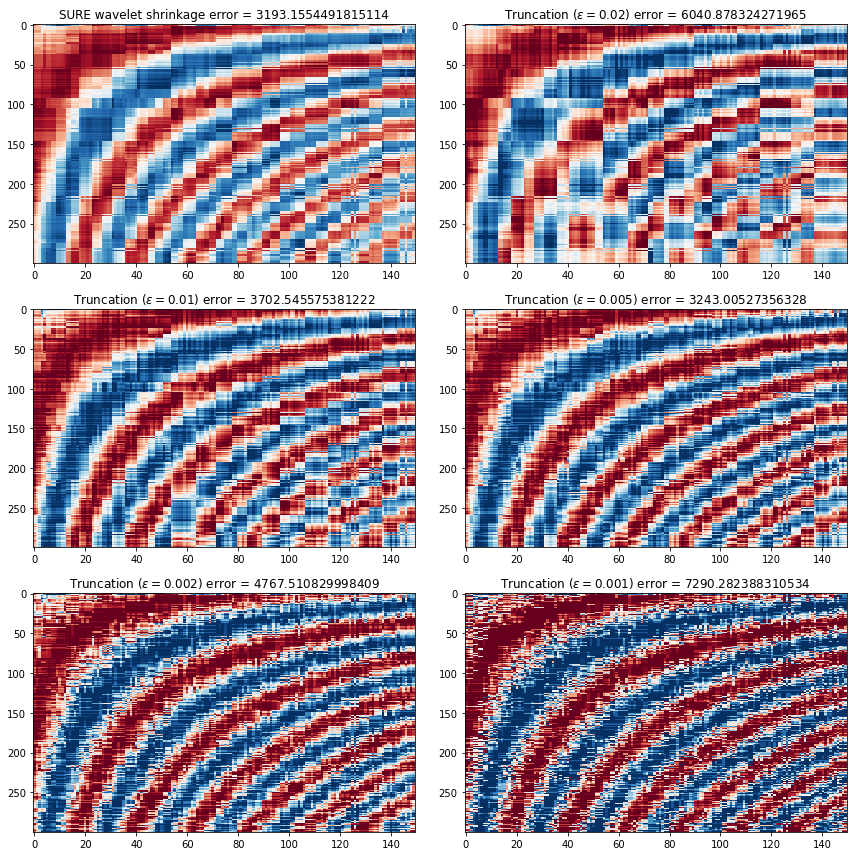

In [13]:
fig = plt.figure(figsize=(12,12))
fig.add_subplot(321)
recon = tree_recon.recon_2d_sure(data,row_tree,col_tree)
tree_recon.threshold_recon(recon,-1.0,1.0)
err = np.sum((recon-shuffled_means_matrix)**2)
cplot(recon[row_order,:][:,col_order])
plt.title("SURE wavelet shrinkage error = {}".format(err))
for idx,epsilon in enumerate([0.02,0.01,0.005,0.002,0.001]):
    fig.add_subplot(3,2,idx+2)
    recon = tree_recon.recon_2d_haar_folder_size(data,row_tree,col_tree,epsilon)
    tree_recon.threshold_recon(recon,-1.0,1.0)
    cplot(recon[row_order,:][:,col_order])
    err = np.sum((recon-shuffled_means_matrix)**2)
    plt.title("Truncation $(\epsilon = {}$) error = {}".format(epsilon,err))
plt.tight_layout()
plt.show()

So we see that SURE performs best in this error metric, while the truncation reconstructions have to balance inaccuracy, where $\epsilon$ is too large, so that detail is lost, with overfitting, where $\epsilon$ is too small, so that we are coming closer to reconstructing the data than reconstructing the probability field.

### Improvement through Spin Cycling

We can improve both of these methods by spin cycling. Here we run the questionnaire process seven times, with different tree constants each time. Then we cross match the row and column trees from the seven runs, generating 49 tree-pairs with which we reconstruct the probability field. We compare the average of the 49 reconstructions on SURE and on the values of $\epsilon$ above.

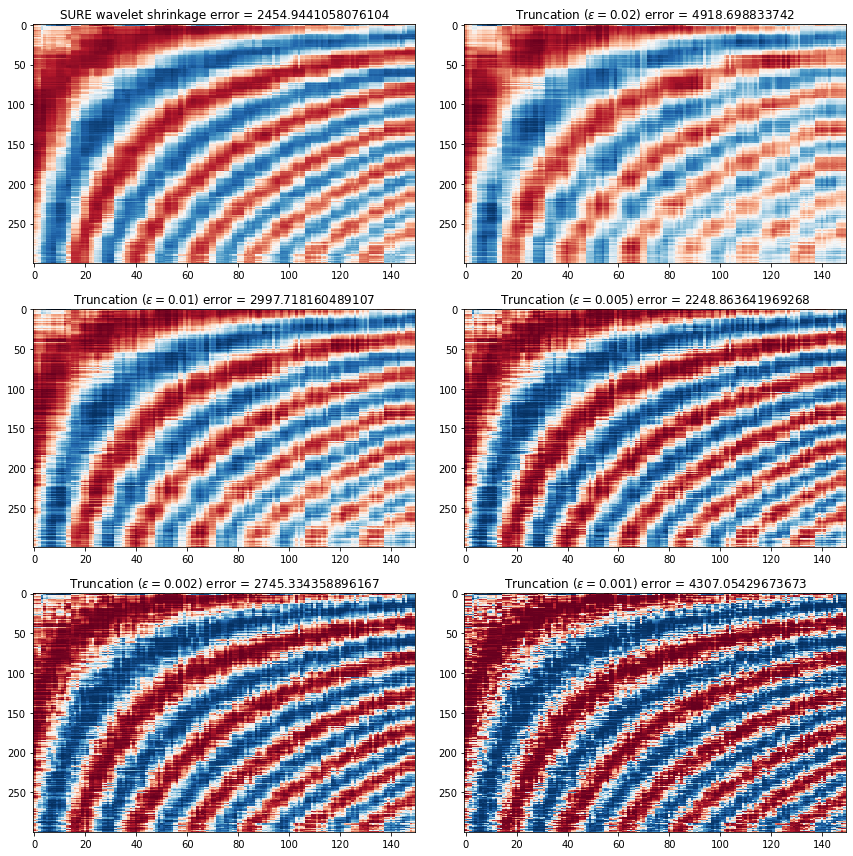

In [14]:
tree_constants = [0.1,0.3,0.5,0.75,1.0,1.5,2.0]
params_list = []
for tree_constant in tree_constants:
    kwargs = {}
    kwargs["n_iters"] = 2
    kwargs["threshold"] = 0.0
    kwargs["row_alpha"] = 0.0
    kwargs["col_alpha"] = 0.0
    kwargs["row_beta"] = 1.0
    kwargs["col_beta"] = 1.0
    kwargs["tree_constant"] = tree_constant
    params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_COS_SIM,
                                         questionnaire.TREE_TYPE_FLEXIBLE,
                                         questionnaire.DUAL_EMD,
                                         questionnaire.DUAL_EMD,**kwargs)
    params_list.append(params)

qruns = []
for params in params_list:
    qruns.append(questionnaire.pyquest(data,params))
    
sure_recon = np.zeros(data.shape)
trunc_recons = []
for idx,epsilon in enumerate([0.02,0.01,0.005,0.002,0.001]):
    trunc_recons.append(np.zeros(data.shape))

for qrun in qruns:
    for qrun2 in qruns:
        row_tree = qrun.row_trees[-1]
        col_tree = qrun2.col_trees[-1]
        sr = tree_recon.recon_2d_sure(data,row_tree,col_tree)
        tree_recon.threshold_recon(sr,-1.0,1.0)
        sure_recon += sr
        for idx,epsilon in enumerate([0.02,0.01,0.005,0.002,0.001]):
            tr = tree_recon.recon_2d_haar_folder_size(data,row_tree,col_tree,epsilon)
            tree_recon.threshold_recon(tr,-1.0,1.0)
            trunc_recons[idx] += tr
sure_recon /= (len(qruns)**2)
for idx,epsilon in enumerate([0.02,0.01,0.005,0.002,0.001]):
    trunc_recons[idx] /= (len(qruns)**2)

fig = plt.figure(figsize=(12,12))
fig.add_subplot(321)
cplot(sure_recon[row_order,:][:,col_order])
err = np.sum( (sure_recon-shuffled_means_matrix)**2 )
plt.title("SURE wavelet shrinkage error = {}".format(err))
for idx,epsilon in enumerate([0.02,0.01,0.005,0.002,0.001]):
    fig.add_subplot(3,2,idx+2)
    cplot(trunc_recons[idx][row_order,:][:,col_order])
    err = np.sum( (trunc_recons[idx]-shuffled_means_matrix)**2 )
    plt.title("Truncation $(\epsilon = {}$) error = {}".format(epsilon,err))
plt.tight_layout()
plt.show()

So we see here that spin cycling can removes many artifacts and improve the performance of partition tree-based estimators and the estimator based on SURE alike, reducing the error in this case by almost a third or more from a single run. 

### Binary Trees (and spin cycling)

We finish by presenting the outcomes of processing the entire questionnaire process using randomized binary trees. The overall reconstruction performance for these trees is poorer because the binary tree structure limits the accuracy of the model. However, the reconstructions still benefit significantly from spinning, with a near 50% reduction in error from 100 row-column tree pairs.

In [15]:
bal_constants = [1.0,1.3,1.5,1.8,2.1,1.6,1.5,2.1,1.6,1.8]
params_list = []
for bal_constant in bal_constants:
    kwargs = {}
    kwargs["n_iters"] = 2
    kwargs["threshold"] = 0.0
    kwargs["row_alpha"] = 1.0
    kwargs["col_alpha"] = 1.0
    kwargs["row_beta"] = 0.0
    kwargs["col_beta"] = 0.0
    kwargs["tree_constant"] = bal_constant
    params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_COS_SIM,
                                         questionnaire.TREE_TYPE_BINARY,
                                         questionnaire.DUAL_EMD,
                                         questionnaire.DUAL_EMD,**kwargs)
    params_list.append(params)
qruns = []
for params in params_list:
    qruns.append(questionnaire.pyquest(data,params))
epsilon = 0.0015
binary_recons = np.zeros([len(qruns)**2] + list(data.shape))
idx = 0
for qrun in qruns:
    for qrun2 in qruns:
        row_tree = qrun.row_trees[-1]
        col_tree = qrun2.col_trees[-1]
        tr = tree_recon.recon_2d_haar_folder_size(data,row_tree,col_tree,epsilon)
        tree_recon.threshold_recon(tr,-1.0,1.0)
        binary_recons[idx] = tr
        idx += 1
br_spun = np.mean(binary_recons,axis=0)

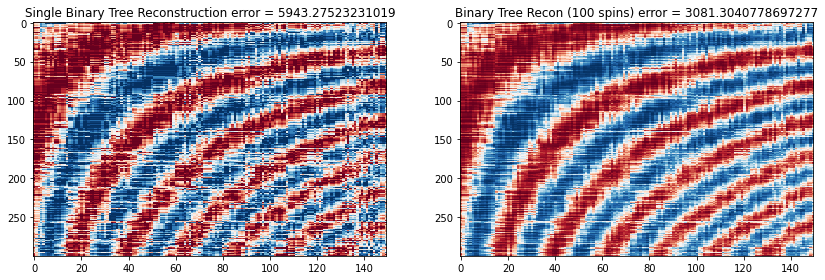

In [16]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
cplot(binary_recons[50][row_order,:][:,col_order])
err = np.sum( (binary_recons[50]-shuffled_means_matrix)**2 )
plt.title("Single Binary Tree Reconstruction error = {}".format(err))
fig.add_subplot(122)
cplot(br_spun[row_order,:][:,col_order])
err = np.sum( (br_spun-shuffled_means_matrix)**2 )
plt.title("Binary Tree Recon (100 spins) error = {}".format(err))
plt.tight_layout()
plt.show()